In [1]:
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot
from PySDM.physics import si, in_unit
from PySDM import Formulae
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
formulae = Formulae(
    isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994',
    isotope_meteoric_water_line_excess='Dansgaard1964'
)
const = formulae.constants

N = 5
ix_T = 0
ix_qv = 1
ix_ql = 2
ix_R_2H = 3
ix_R_18O = 4

R0 = {
    ix_R_2H: const.VSMOW_R_2H,
    ix_R_18O: const.VSMOW_R_18O
}

# TODO: use parcel env instead!
y0 = np.empty(N)
y0[ix_T] = const.T0 + 25 * si.K
y0[ix_qv] = 10 * si.g / si.kg
y0[ix_ql] = 0
# TODO: common delta_2_R !
y0[ix_R_2H] = formulae.trivia.isotopic_delta_2_ratio(delta=-74.7 * const.PER_MILLE, reference_ratio=R0[ix_R_2H])
y0[ix_R_18O] = formulae.trivia.isotopic_delta_2_ratio(delta=(-74.7-10)/8 * const.PER_MILLE, reference_ratio=R0[ix_R_18O])  # TODO: 8/10 from formulae!

alphas = {
    ix_R_2H: formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H,
    ix_R_18O: formulae.isotope_equilibrium_fractionation_factors.alpha_l_18O,
}

def dy_dz(z, y):
    dy_dz = np.zeros(N)
    dy_dz[ix_T] = -6.5 * si.K / si.km  # TODO: arbitrary value!
    dy_dz[ix_ql] = 2 * si.g / si.kg / si.km  # TODO: arbitrary value!
    dy_dz[ix_qv] = - dy_dz[ix_ql]

    for iso in (ix_R_2H, ix_R_18O):
        dalpha_dT = (  # TODO: analytic deriv in formulae?
            alphas[iso](y[ix_T] + .5 * si.K)
            -
            alphas[iso](y[ix_T] - .5 * si.K)
        ) / 1 * si.K
        alpha = alphas[iso](y[ix_T])

        # TODO: into trivia? (+ test that for Nl=0 & dalpha=0, one gets Rayleigh formula)
        dy_dz[iso] = y[iso] / (y[ix_qv] + alpha * y[ix_ql]) * (
            (alpha - 1) * dy_dz[ix_qv] 
            -
            y[ix_ql] * dalpha_dT * dy_dz[ix_T]
        )
    return dy_dz
    
z_max = 7000 * si.m
integ = solve_ivp(
    fun=dy_dz,
    t_span=(0, z_max),
    y0=y0,
    t_eval=np.linspace(0, z_max, 25)
)
assert integ.success, integ.message

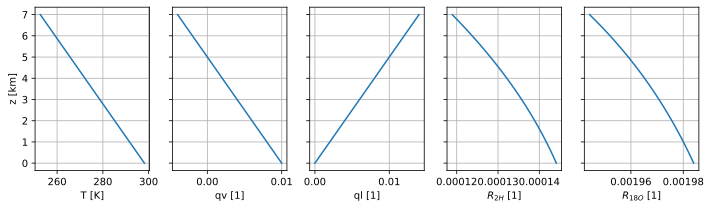

HTML(value="<a href='./model_state.pdf' target='_blank'>./model_state.pdf</a><br>")

In [3]:
fig, axs = pyplot.subplots(1, N, sharey=True, tight_layout=True, figsize=(10, 3))

labels = [""] * N
labels[ix_T] = "T [K]"
labels[ix_qv] = "qv [1]"
labels[ix_ql] = "ql [1]"
labels[ix_R_2H] = "$R_{2H}$ [1]"
labels[ix_R_18O] = "$R_{18O}$ [1]"

for i, label in enumerate(labels):
    axs[i].plot(integ.y[i], integ.t / si.km)
    axs[i].set_xlabel(label)

axs[0].set_ylabel("z [km]")
for ax in axs:
    ax.grid()

show_plot('model_state.pdf')

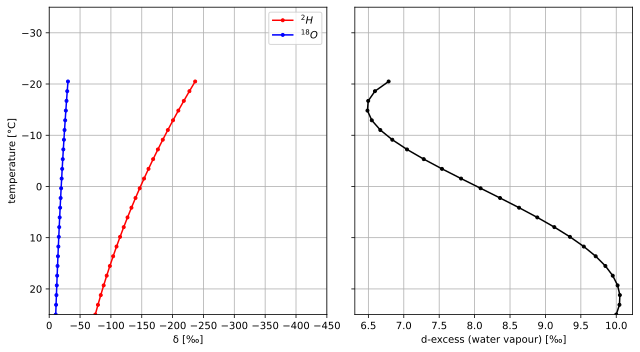

HTML(value="<a href='./fig_4_plus_18O_plus_excess.pdf' target='_blank'>./fig_4_plus_18O_plus_excess.pdf</a><br…

In [4]:
fig, axs = pyplot.subplots(1, 2, sharey=True, tight_layout=True, figsize=(9, 5))
T_C = integ.y[ix_T] - const.T0
delta = {}
for iso in (ix_R_2H, ix_R_18O):
    delta[iso] = formulae.trivia.isotopic_ratio_2_delta(ratio=integ.y[iso], reference_ratio=R0[iso])
    axs[0].plot(
        in_unit(delta[iso], const.PER_MILLE),
        T_C,
        marker='.',
        color={ix_R_2H: 'red', ix_R_18O: 'blue'}[iso],
        label={ix_R_2H: '$^2H$', ix_R_18O: '$^{18}O$'}[iso]
    )
axs[0].legend()
axs[0].set_xlabel("δ [‰]")
axs[0].set_ylabel("temperature [°C]")
axs[0].set_xlim(0, -450)
axs[0].set_ylim(25, -35)
axs[0].grid()

axs[1].plot(
    in_unit(
        formulae.isotope_meteoric_water_line_excess.excess_d(delta[ix_R_2H], delta[ix_R_18O]),
        const.PER_MILLE
    ),
    T_C,
    color='black',
    marker='.'
)
axs[1].grid()
axs[1].set_xlabel("d-excess (water vapour) [‰]")
show_plot('fig_4_plus_18O_plus_excess.pdf')